# Computing the distribution of protein with the solution of the chemical master equation for a two state promoter.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [1]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

#  Analytical solution of the chemical master equation for the two-state promoter protein distribution

[Shahrezaei and Swain](http://www.pnas.org/content/105/45/17256.short) go into the amazing task of deriving the analytical distribution of the protein copy number for a two-state promoter. To define the distribution let's write the possible reactions that can happen.
\begin{align}
\begin{array}{cc}
\text{reaction} & \text{rate}\\
\text{active} \rightarrow \text{inactive} & k_{off}\\
\text{inactive} \rightarrow \text{active} & k_{on}\\
m \rightarrow m+1 & r_m\\
m \rightarrow m-1 & m \cdot \gamma_m\\
p \rightarrow p+1 & r_p\\
p \rightarrow p-1 & p \cdot \gamma_p\\
\end{array}
\end{align}

Having defined all the possible reactions we can now list a series of definitions that will simplify writing down the distribution.
\begin{align}
a &\equiv \frac{r_m}{\gamma_p}\\
b &\equiv \frac{r_p}{\gamma_m}\\
\gamma &\equiv \frac{\gamma_m}{\gamma_p}\\
K_{on} &\equiv \frac{k_{on}}{\gamma_p}\\
K_{off} &\equiv \frac{k_{off}}{\gamma_p}\\
\end{align}
and
\begin{align}
\alpha &\equiv \frac{1}{2}(a + K_{on} + K_{off} + \phi)\\
\beta &\equiv \frac{1}{2}(a + K_{on} + K_{off} - \phi)\\
\end{align}
 with
 \begin{equation}
\phi ^2 = \left( a + K_{on} + K_{off} \right)^2 - 4 a K_{on}
 \end{equation}

Using all these definitions we can finally write down the steady state distribution of protein $P_{st}(p)$
\begin{align}
P_{st}(p) = &\frac{\Gamma (\alpha + p) \Gamma (\beta + p) \Gamma (K_{on} + K_{off})}{\Gamma (p + 1) \Gamma (\alpha) \Gamma (\beta) \Gamma (K_{on} + K_{off} + p)} \times \\
&\left( \frac{b}{1 + b} \right)^p \left( 1 - \frac{b}{1 + b} \right)^\alpha \times\\
& F^2_1 \left( \alpha + p, K_{on} + K_{off} - \beta, K_{on} + K_{off} + p; \frac{b}{1 + b} \right),
\end{align}
where $F^2_1$ is the [Gauss Hypergeometric function](http://mathworld.wolfram.com/HypergeometricFunction.html).

The mean of this distribution is given by
\begin{equation}
\left\langle p \right\rangle = \frac{\frac{r_m}{\gamma_m}\frac{r_p}{\gamma_p} k_{on}}{k_{on} + k_{off}}.
\end{equation}

As before it is better to work with the log of the distribution, therefore taking the log of that monster gives
\begin{align}
\ln P_{st}(p) = &\ln \Gamma (\alpha + p) + ln \Gamma (\beta + p) + \ln \Gamma (K_{on} + K_{off}) \\
&- \ln \Gamma (p + 1) - \ln \Gamma (\alpha) - \ln \Gamma (\beta) - \ln \Gamma (K_{on} + K_{off} + p)\\
&+ p\left[ \ln b - \ln(1 - b)\right] + \alpha \ln \left( 1 - \frac{b}{1 + b} \right)\\
&+ \ln F^2_1 \left( \alpha + p, K_{on} + K_{off} - \beta, K_{on} + K_{off} + p; \frac{b}{1 + b} \right),
\end{align}

## Including the effect of the inducer.

Just as with the mRNA distribution, the effect of the inducer in the regulation is capture in the $k_{off}$ parameter.
Therefore we compute the conditional probability
\begin{equation}
 P(p \mid C, R) = P \left(p \mid k_{off} = k_0 \cdot R \cdot p_{act}(C)\right)
\end{equation}

In [119]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_gauss_hyp = np.frompyfunc(lambda a, b, c, z: \
mpmath.ln(mpmath.hyp2f1(a, b, c, z,  maxprec=10000)).real, 4, 1)

def log_p_p_mid_C(C, protein, rep, ka, ki, epsilon, kon, k0, gamma_m, r_gamma_m,
                  gamma_p, r_gamma_p, logC=False):
    '''
    Computes the log conditional probability lnP(p|C,R), 
    i.e. the probability of having p proteins given 
    an inducer concentration C and a repressor copy number R.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    protein : array-like.
        protein copy number at which evaluate the probability.        
    rep : float.
        repressor copy number per cell.
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
    kon : float.
        rate of activation of the promoter in the chemical master equation
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    gamma_m : float.
        half-life time for the mRNA.
    r_gamma_m : float.
        average number of mRNA in the unregulated promoter.
    gamma_p : float.
        half-life time for the protein.
    r_gamma_p : float.
        average number of protein per mRNA in the unregulated promoter.
    logC : Bool.
        boolean indicating if the concentration is given in log scale. If True
        C = 10**C
    Returns
    -------
    log probability lnP(p|c,R)
    '''
    # Convert C and mRNA into np.arrays
    C = np.array(C)
    protein = np.array(protein)
    # Convert from log if necessary
    if logC:
        C = 10**C
 
    # Calculate the off rate including the MWC model
    koff = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)

    # compute the variables needed for the distribution
    a = r_gamma_m * gamma_m / gamma_p # r_m / gamma_p
    b = r_gamma_p * gamma_p / gamma_m # r_p / gamma_m
    gamma = gamma_m / gamma_p
    Kon = kon / gamma_p
    Koff = koff / gamma_p
    
    phi = np.sqrt((a + Kon + Koff)**2 - 4 * a * Kon)
    
    alpha = 1 / 2 * (a + Kon + Koff + phi)
    beta = 1 / 2 * (a + Kon + Koff - phi)
    
    # Compute the probability
    lnp = scipy.special.gammaln(alpha + protein) \
    + scipy.special.gammaln(beta + protein) \
    + scipy.special.gammaln(Kon + Koff) \
    - scipy.special.gammaln(protein + 1) \
    - scipy.special.gammaln(alpha) \
    - scipy.special.gammaln(beta) \
    - scipy.special.gammaln(Kon + Koff + protein) \
    + protein * (np.log(b) - np.log(1 + b)) \
    + alpha * np.log(1 - b / (1 + b)) \
    + np_log_gauss_hyp(alpha + protein, Kon + Koff - beta,
            Kon + Koff + protein, b / (1 + b))
    return lnp.astype(float)

# Fitting the $k_{on}$ and $k_{off}$ from experimental data.

As we explained in the mRNA analytical solution when defining the parametres for the equation, if we want to be self consistent between the thermodynamic picture and the chemical master equation framework the **mean** fold-change **at the mRNA level** should satisfy

\begin{equation}
\text{fold-change} = \frac{1}{1 + \frac{k_0 \cdot p_{act} \cdot [R]}{k_{on}}} = \frac{1}{1 + \frac{2R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}}
\end{equation}

But actually since the mean protein level is given by

\begin{equation}
\left\langle p \right\rangle = \frac{\frac{r_m}{\gamma_m}\frac{r_p}{\gamma_p} k_{on}}{k_{on} + k_{off}}.
\end{equation}

the terms depending on the production and degradation of protein and mRNA cancel out when computing the fold change and the functional form of the mean fold change ends up being the exact same as for the mRNA level.

This ends up constraining the ratio $k_0 / k_{on}$ such that it is consistent with the energies measured by Hernan as explained before. But there is some doubt about the validity of the $k_0$ value that we quoted from the Elf et. al paper. The main reason is that for the two state model we are explicitly ignoring the empty promter state in order to make analytical progress. That means that the parameter measured by Elf et al. doesn't reflect the reality of this model as it is a rate from the empty to the repressed promoter. What we need for this model is an "effective rate" from the active to the inactive promoter that includes all the processes that happen in between.

An alternative way to obtain these two rates is to use the *single-cell information* that microscopy provides. The difference is that we can not only compute the first moment, but we can make use of the noise in gene expression to obtain these parameters.

In their paper [Shahrezaei and Swain](http://www.pnas.org/content/105/45/17256.short) derive the expression for the noise defined as 

\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle},
\end{equation}

i.e. the standard deviation over the mean. They claim that the noise should satisfy

\begin{equation}
\eta^2 = \frac{1}{\langle p \rangle} + \frac{\gamma_p}{\gamma_m} \frac{1}{\langle m \rangle} + \frac{\gamma_p}{\gamma_p + k_{on} + k_{off}} \frac{k_{off}}{k_{on}}.
\end{equation}

If we include the assumption that $k_{off} \equiv k_{off}([R])$ and we substitude the definition of mean protein and mean mRNA copy number we find that the noise scales with the number of repressors as

\begin{equation}
\eta^2([R]) = \frac{k_{on} + k_0[R]}{\frac{r_m}{\gamma_m} \frac{r_p}{\gamma_p} k_{on}} + \frac{\gamma_p}{\gamma_m} \frac{k_{on} + k_0[R]}{k_{on} \frac{r_m}{\gamma_m}} + \frac{\gamma_p}{\gamma_p + k_{on} + k_{0}[R]} \frac{k_{0}[R]}{k_{on}}.
\end{equation}

Let's implement a function to compute this noise

In [2]:
def noise_protein(C, rep, ka, ki, epsilon, kon, k0, 
                     gamma_m, r_gamma_m,
                     gamma_p, r_gamma_p):
    '''
    Computes the noise in gene expression as a function of all the parameters
    that go into the chemical master equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    repressor : float.
        repressor copy number per cell.
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    omega : float.
        energetic barrier between the inactive and the active state.
    kon : float.
        rate of activation of the promoter in the chemical master equation
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    gamma_m : float.
        half-life time for the mRNA.
    r_gamma_m : float.
        average number of mRNA in the unregulated promoter.
    gamma_p : float.
        half-life time for the protein.
    r_gamma_p : float.
        average number of protein per mRNA in the unregulated promoter.
    Returns
    -------
    eta the noise in protein distribution
    '''
    # Convert C into np.array
    C = np.array(C)
    # Calculate the off rate including the MWC model
    koff = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    
    # Compute the noise
    mean_m = r_gamma_m * kon / (kon + koff)
    mean_p = r_gamma_m * r_gamma_p * kon / (kon + koff)
    gamma = gamma_m / gamma_p
    return np.sqrt(1 / mean_p + 1 / gamma * 1 / mean_m +\
           gamma_p / (gamma_p + kon + koff) * koff / kon)

Let's compute the noise for different values of $k_0$ changing $k_{off}$ to satisfy the thermodynamic model

In [174]:
# Specify some parameters
k0_array = np.logspace(-8, -3, 200)
repressors = [22, 60, 124, 260, 1220, 1740]
binding_energy = -15.3
prot_params = dict(ka=139, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=10000)

# Compute noise as a function the diffusion limited value and repressor number
noise_array = np.empty([len(k0_array), len(repressors)])
for i, k0 in enumerate(k0_array):
    for j, rep in enumerate(repressors):
    # Repressor copy number of my favorite strain RBS1027
        prot_params['rep'] = rep * 1.66
        prot_params['k0'] = k0
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        noise_array[i, j] = noise_protein(0, **prot_params)

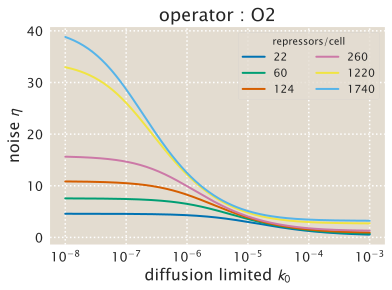

In [175]:
fig = plt.figure()
for j, r in enumerate(repressors):
    plt.plot(k0_array, noise_array[:, j],
            label=str(r))
plt.xscale('log')
plt.xlabel('diffusion limited $k_0$')
plt.ylabel(r'noise $\eta$')
plt.title('operator : O2')
plt.legend(loc=0, ncol=2, title='repressors/cell')

So indeed this diffusion limited has a clear effect on the noise in gene expression.

### Noise variation as a function of other parameters.

As an interesting exploration let's look at how the noise $\eta$ changes as other parameters such as the mean number of mRNA, proteins or their degradation rates change.

In [240]:
# Specify some parameters
gamma_m_array = np.linspace(3, 10, 50)
repressors = [22, 60, 124, 260, 1220, 1740]
binding_energy = -15.3
prot_params = dict(ka=139, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=10000,
                   k0=2.7E-3)

# Compute noise as a function the diffusion limited value and repressor number
noise_array = np.empty([len(gamma_m_array), len(repressors)])
for i, gamma in enumerate(gamma_m_array):
    for j, rep in enumerate(repressors):
    # Repressor copy number of my favorite strain RBS1027
        prot_params['rep'] = rep * 1.66
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        prot_params['gamma_m'] = 1 / (gamma * 60)
        noise_array[i, j] = noise_protein(0, **prot_params)

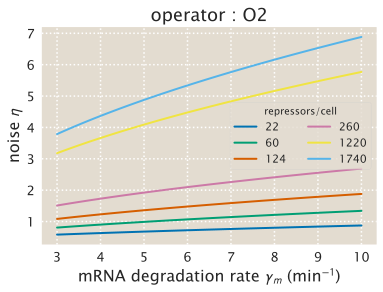

In [241]:
fig = plt.figure()
for j, r in enumerate(repressors):
    plt.plot(gamma_m_array, noise_array[:, j],
            label=str(r))
plt.xlabel('mRNA degradation rate $\gamma_m$ (min$^{-1}$)')
plt.ylabel(r'noise $\eta$')
plt.title('operator : O2')
plt.legend(loc=0, ncol=2, title='repressors/cell')

# Fitting the rates to microscopy data

The idea is to obtain a value for $k_0$ and $k_{on}$ based on the experimental microscopy data.

For this exercise we will use the microscopy data gathered so far.

In [235]:
# Read the tidy-data frame
# mwc_files = glob.glob('../../data/csv_microscopy/mwc_data/*csv')
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,area,eccentricity,solidity,mean_intensity
0,20161118,mrazomej,O2,-13.9,auto,0,0.0,4.1984,0.962913,0.896175,91.284559
1,20161118,mrazomej,O2,-13.9,auto,0,0.0,3.9424,0.947307,0.922156,79.274082
2,20161118,mrazomej,O2,-13.9,auto,0,0.0,2.7904,0.887267,0.947826,92.690586
3,20161118,mrazomej,O2,-13.9,auto,0,0.0,3.7888,0.946231,0.896970,90.192167
4,20161118,mrazomej,O2,-13.9,auto,0,0.0,4.0704,0.954322,0.898305,72.529495


Having read the data let's compute the average noise for the different concentrations. Consider that the noise is defined as
\begin{equation}
\eta \equiv \frac{\sqrt{\left\langle p^2 \right\rangle - \left\langle p \right\rangle^2}}{\left\langle p \right\rangle},
\end{equation}

This means that since the mean protein copy number $\left\langle p \right\rangle$ is involved we need to take into account the **autofluorescence**. So to compute this quantity from the fluroescence measurements we need to compute
\begin{equation}
\eta = \frac{\sqrt{\left\langle (I  - \langle I_{\text{auto}}\rangle)^2 \right\rangle - \left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle^2}}{\left\langle (I  - \langle I_{\text{auto}}\rangle) \right\rangle},
\end{equation}
where $I$ is the intensity of the objective strain and $\langle I_{\text{auto}}\rangle$ is the mean autofluorescence intensity.

The datasets were taken with a single delta sample and a single autofluorescence sample. So we will compute the noise using the same auto for all IPTG concentrations.

In [242]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
df_noise = pd.DataFrame(columns=['date', 'IPTG_uM','operator', 'binding_energy',
                                 'rbs', 'repressors', 'mean', 'std', 'noise'])
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0],
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).std(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2])
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=['date', 'IPTG_uM', 'operator',
                                             'binding_energy',  'rbs', 
                                             'repressors', 'mean', 
                                             'std', 'noise'])
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise
0,20161118,0.0,O2,-13.9,RBS1027,130,28.660991,34.292514,1.196487
1,20161118,0.1,O2,-13.9,RBS1027,130,29.234495,34.792041,1.190102
2,20161118,5.0,O2,-13.9,RBS1027,130,71.514148,53.193801,0.743822
3,20161118,10.0,O2,-13.9,RBS1027,130,129.849144,87.332807,0.672571
4,20161118,25.0,O2,-13.9,RBS1027,130,391.288683,240.143667,0.613725


(-0.5, 8402.7716270925066)

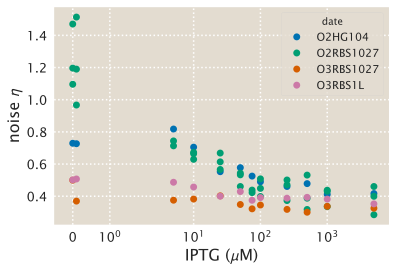

In [243]:
df_group = df_noise.groupby(['operator', 'rbs'])
    
for group, data in df_group:
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1])
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
# plt.ylim([-1, 50])
# plt.yscale('log')

Let's find the value of the parameter that satisfies this mean noise level. For this we will use the `scipy.optimize.root` function.

In [244]:
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000)

prot_params['gamma_m'] = 1 / (3 * 60)
def root_fn(k0, df, prot_params):
    '''
    function to find the root that satisfies the mean noise level
    '''
    # Extract parameters
    prot_params['k0'] = k0
    
    # Group by date and concentration
    noise_group = df.groupby(['date','IPTG_uM'])
    
    residuals = []
    # Loop through groups returning the residuals
    for group, data in noise_group:
        # Specify parameters for specific data set
        binding_energy = data.binding_energy.unique()[0]
        repressors = data.repressors.unique()[0]
        prot_params['rep'] = 2 * 1.66 * repressors
        prot_params['kon'] = chann_cap.kon_fn(binding_energy, k0)
        
        # Compute experimental noise
        avg_noise = data.noise
        # Append linear residuals
        residuals.append(np.array(noise_protein(group[1], **prot_params) -\
                                  avg_noise))
        # Append the residuals of the log
#         residuals.append(np.array(np.log(noise_protein(group[1], **prot_params))\
#                                    - np.log(avg_noise)))
    return np.array(residuals).ravel()


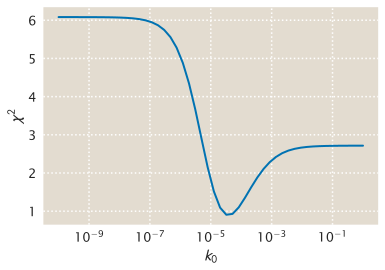

In [217]:
# Let's plot the sum of the square of the residuals as a function of different
# selections of the k0 parameter.
k0_array = np.logspace(-10, 0, 50)
df = df_noise[(df_noise.operator=='O2') & (df_noise.rbs=='HG104')]
plt.plot(k0_array, [np.sum(root_fn(ko, df, prot_params)**2) for ko in k0_array])
plt.xlabel(r'$k_0$')
plt.xscale('log')
plt.ylabel(r'$\chi^2$')

In [218]:
sol = scipy.optimize.least_squares(root_fn, 1E-4, args=(df, prot_params))
k0_fit = sol.x[0]
print('k0 = {:.7f}'.format(k0_fit))

k0 = 0.0000384


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


###  Testing this parameter fit with all the data.

Having obtained a value for the $k_0$ parameter let's see how well it predicts the noise from different strains.

In [245]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 50)

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000,
                   k0=k0_fit)

(-0.5, 17398.189457156805)

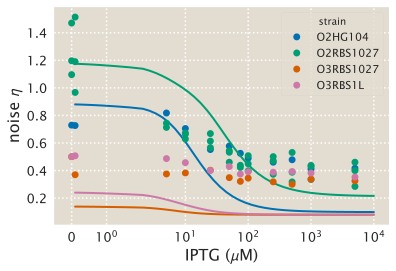

In [246]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # Compute the kon based on Hernan's binding energy and the k0 value
    prot_params['kon'] = chann_cap.kon_fn(epsilon=energies[group[0]],
                                         k0=prot_params['k0'])
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
# plt.ylim([-1, 5])
# plt.yscale('log')

##  Fitting the parameter to all of the available data.

A different approach to find the best fit parameter is to use all of the available data rather than a single strain. Let's see how different the value would be.

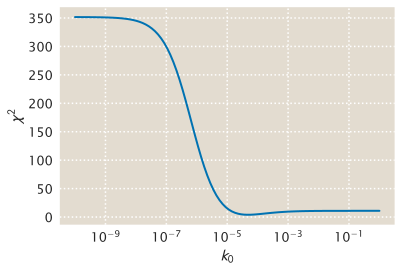

In [247]:
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000)

# Let's plot the sum of the square of the residuals as a function of different
# selections of the k0 parameter.
k0_array = np.logspace(-10, 0, 100)
plt.plot(k0_array, [np.sum(root_fn(ko, df_noise, prot_params)**2)\
                    for ko in k0_array])
plt.xlabel(r'$k_0$')
plt.xscale('log')
plt.ylabel(r'$\chi^2$')

In [248]:
sol = scipy.optimize.least_squares(root_fn, 1E-4, args=(df, prot_params))
k0_global_fit = sol.x[0]
print('k0 = {:.7f}'.format(k0_global_fit))

k0 = 0.0000384


/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [249]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 200)

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000,
                   k0=k0_global_fit)

(-0.5, 17398.189457156805)

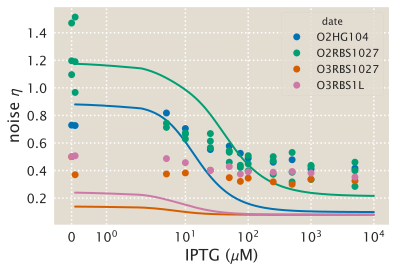

In [250]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # Compute the kon based on Hernan's binding energy and the k0 value
    prot_params['kon'] = chann_cap.kon_fn(epsilon=energies[group[0]],
                                         k0=prot_params['k0'])
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.xlim(left=-5E-1)
# plt.ylim([-1, 5])
# plt.yscale('log')

# Testing Brewster & Jones parameters

Let's try using the parameters that Brewster and Jones report in their 2014 [paper](http://science.sciencemag.org/content/346/6216/1533.full). For this they used the diffusion limited rate reported by Elf et al. For the repressor dissociation rate they used an *in vitro* measurement done for Oid and then used the ratios of the binding sites equilibrium occupancies compared to Oid in order to determine the values for the other operators.

Let's implement these values

In [211]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 200)

# Define dictionary containing the kon rates according to Jones & Brewster
kon_dict = {'Oid': 0.0023, 'O1': 0.0069, 'O2': 0.091, 'O3': 2.1}

# Define the CME parameters
prot_params = dict(ka=139.55, ki=0.53, epsilon=4.5,
                   gamma_m=0.00284, r_gamma_m=15.7,
                   gamma_p=0.000277, r_gamma_p=1000,
                   k0=2.7E-3)

(-0.5, 17398.189457156805)

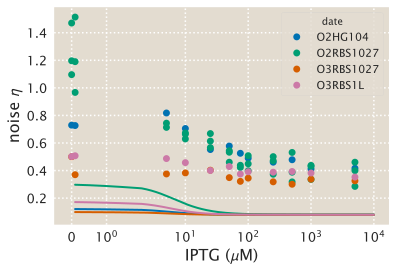

In [212]:
# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))
i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    energy = data.binding_energy.unique()[0]
    repressors = data.repressors.unique()[0]
    # determine kon based on Jones and Brewster 2014
    prot_params['kon'] = kon_dict[data.operator.unique()[0]]
    # Indicate the repressor copy number
    prot_params['rep'] = repressors * 1.66 * 2
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = noise_protein(C=IPTG, **prot_params)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, data.noise, lw=0, marker='o',
            label=group[0] + group[1], color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='date')
plt.xlim(left=-5E-1)
plt.xlim(left=-5E-1)
# plt.ylim([-1, 5])
# plt.yscale('log')